In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import timeit
import math
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df_joaquim = pd.read_excel('../data/processed/bronze/joaquim.xlsx')
df_joaquim.head()

,t_acumulated[s],U[V],I[A],SOC,Uo_OCV
0,0,353.016082,0.0,0.0,386.132282
1,1,392.722154,0.0,0.0,386.132282
2,2,392.799002,0.0,0.0,386.132282
3,3,392.800000,0.0,0.0,386.132282
4,4,392.773000,0.0,0.0,386.132282


In [47]:
def calculate_scaled_soc(df):
    Ah_cap = 51
    df['dt'] = df['soc'].shift(1, fill_value=0)
    df['soc'] = 0
    df['soc'] = df['soc'].shift(1, fill_value=0) + (df['I[A]'] +
                                                    df['I[A]'].shift(1, fill_value=0))*(df['dt']/(2*3600*Ah_cap))
    episilon = 0.02
    df['scaled_soc'] = df['soc']*(1-2*episilon) + episilon
    return df

def calculate_scaled_soc_v2(df, net_current):
    Ah_cap = net_current
    dt = df['t_acumulated[s]'].diff().iloc[1]    
    df['past_I[A]'] = df['I[A]'].shift(1, fill_value=0)
    
    df.loc[df.index[0], 'soc'] = 0
    # Calculate the SOC column iteratively
    for i in range(1, len(df)):
        actual_current = df.loc[df.index[i], 'I[A]']
        past_current = df.loc[df.index[i-1], 'past_I[A]']
        df.loc[df.index[i], 'soc'] = df.loc[df.index[i-1], 'soc'] + (actual_current+past_current)*(dt/(2*3600*Ah_cap))
    
    episilon = 0.02
    df['scaled_soc'] = df['soc']*(1-2*episilon) + episilon
    return df

In [5]:
df_joaquim = calculate_scaled_soc_v2(df_joaquim, 51)
df_joaquim.head()

,t_acumulated[s],U[V],I[A],SOC,Uo_OCV,past_I[A],soc,scaled_soc
0,0,353.016082,0.0,0.0,386.132282,0.0,0.0,0.02
1,1,392.722154,0.0,0.0,386.132282,0.0,0.0,0.02
2,2,392.799002,0.0,0.0,386.132282,0.0,0.0,0.02
3,3,392.800000,0.0,0.0,386.132282,0.0,0.0,0.02
4,4,392.773000,0.0,0.0,386.132282,0.0,0.0,0.02


In [6]:
sum(df_joaquim['SOC'] - df_joaquim['soc'])

0.4970218635451021

In [7]:
df_joaquim.describe()

,t_acumulated[s],U[V],I[A],SOC,Uo_OCV,past_I[A],soc,scaled_soc
count,5559.000000,5559.000000,5559.000000,5559.000000,5559.000000,5559.000000,5559.000000,5559.000000
mean,2779.000000,356.733659,32.831068,0.457343,356.732682,32.830802,0.457253,0.458963
std,1604.889404,25.757897,40.012550,0.300229,24.439460,40.012763,0.300217,0.288209
min,0.000000,255.915000,-105.260000,0.000000,279.519685,-105.260000,0.000000,0.020000
25%,1389.500000,344.952500,8.636500,0.164432,350.424966,8.636500,0.164422,0.177845
50%,2779.000000,365.892000,26.060000,0.431325,366.332020,26.060000,0.431344,0.434090
75%,4168.500000,373.526500,52.190000,0.698045,373.173374,52.190000,0.697769,0.689858
max,5558.000000,392.800000,277.980000,0.994048,386.132282,277.980000,0.994044,0.974282


In [8]:
def voltage_OCV(df, coeff):
    x = df['scaled_soc'] 
    k_0 = coeff[0]
    k_1 = coeff[1]
    k_2 = coeff[2]
    k_3 = coeff[3]
    k_4 = coeff[4]
    k_5 = coeff[5]
    k_6 = coeff[6]
    k_7 = coeff[7]
    OCV = k_0 + k_1/x + k_2/x**2 + k_3/x**3 + k_4/x**4 + k_5*x + k_6*np.log(x) + k_7*np.log(1-x)
    return OCV

# Execução separada

Primeiro realizar mínimos quadrados em OCV e depois realizar em ECM

In [9]:
def calculate_metrics(true, predict):
    MAE = mean_absolute_error(true, predict)
    MSE = mean_squared_error(true, predict)
    RMSE = math.sqrt(MSE)
    R2 = r2_score(true, predict)
    print("MAE: ", MAE, "\nMSE: ", MSE, "\nRMSE: ", RMSE, '\nR²: ', R2)
    return MAE, MSE, RMSE, R2

In [10]:
start = timeit.default_timer()
def voltage_OCV_opt(x, k_0, k_1, k_2, k_3, k_4, k_5, k_6, k_7):
    y = k_0 + k_1/x + k_2/x**2 + k_3/x**3 + k_4/x**4 + k_5*x + k_6*np.log(x) + k_7*np.log(1-x)
    return y

x= np.array(df_joaquim['scaled_soc'])
y =np.array(df_joaquim['U[V]'])
initial_guess =  [400,5, 10, 10, 10, -10, 30, 60]
OCV_python_coeffs, pcov = curve_fit(voltage_OCV_opt, xdata = x, ydata = y, p0=initial_guess,maxfev=40000)
print(OCV_python_coeffs)

df_joaquim['U_OCV_calc[V]'] = voltage_OCV(df_joaquim, OCV_python_coeffs)
print("Duration: ", timeit.default_timer() - start)

[ 2.51251338e+02 -1.85227826e+01  6.08165819e-01 -1.05460016e-02
  7.11347866e-05  2.06886749e+02 -1.06025760e+02  4.64227202e+01]
Duration:  0.14436060000000595


In [11]:
# 2ª ALTERNATIVA
import numpy as np
from scipy.optimize import least_squares

def polynomial_func(x, k):
    k0, k1, k2, k3, k4, k5, k6, k7 = k
    return k0 + k1/x + k2/x**2 + k3/x**3 + k4/x**4 + k5*x + k6*np.log(x) + k7*np.log(1-x)

def objective_function(k, x, y):
    y_pred = polynomial_func(x, k)
    error = (y - y_pred)**2
    return error

# Generate some example data
x =  np.array(df_joaquim['scaled_soc'])
y = np.array(df_joaquim['U[V]'])

# Initial guess for the coefficients
initial_guess = [1, 1, 1, 1, 1, 1, 1, 1]

# Perform the optimization
result = least_squares(objective_function, initial_guess, args=(x, y))

# Extract the optimized coefficients
optimized_coefficients = result.x
print(optimized_coefficients)
df_joaquim['U_OCV_coeff_v2'] = voltage_OCV(df_joaquim, optimized_coefficients)
ocv_residual_error_v2 = sum((df_joaquim['U[V]'] - df_joaquim['U_OCV_coeff_v2'])**2)

df_joaquim.head()

[ 1.86487087e+02 -3.53147842e+01  1.24423343e+00 -2.24972024e-02
  1.52578878e-04  2.90915796e+02 -1.80119266e+02  4.69421369e+01]


,t_acumulated[s],U[V],I[A],SOC,Uo_OCV,past_I[A],soc,scaled_soc,U_OCV_calc[V],U_OCV_coeff_v2
0,0,353.016082,0.0,0.0,386.132282,0.0,0.0,0.02,389.844061,382.299803
1,1,392.722154,0.0,0.0,386.132282,0.0,0.0,0.02,389.844061,382.299803
2,2,392.799002,0.0,0.0,386.132282,0.0,0.0,0.02,389.844061,382.299803
3,3,392.800000,0.0,0.0,386.132282,0.0,0.0,0.02,389.844061,382.299803
4,4,392.773000,0.0,0.0,386.132282,0.0,0.0,0.02,389.844061,382.299803


In [12]:
OCV_python_result = voltage_OCV(df_joaquim, optimized_coefficients)
OCV_MAE_python, OCV_MSE_python, OCV_RMSE_python, OCV_R2_python = calculate_metrics(df_joaquim['U[V]'], OCV_python_result)

MAE:  6.402156785473214 
MSE:  60.651827530367036 
RMSE:  7.787928320828784 
R²:  0.908567366630832


In [13]:
OCV_excel_coeff = [410.9694, 4.4114, -0.090622, 0.001183, -0.00000943, -27.08580, 27.946744, 29.58301]
OCV_excel_result = voltage_OCV(df_joaquim, OCV_excel_coeff)
print("Excel result")
print("Coefficients (k0 -> k7): ", OCV_excel_coeff)
OCV_MAE_excel, OCV_MSE_excel, OCV_RMSE_excel, OCV_R2_excel = calculate_metrics(df_joaquim['U[V]'], OCV_excel_result)

print("\nPython result")
print("Coefficients (k0 -> k7): ", OCV_python_coeffs)
OCV_python_result = voltage_OCV(df_joaquim, OCV_python_coeffs)
OCV_MAE_python, OCV_MSE_python, OCV_RMSE_python, OCV_R2_python = calculate_metrics(df_joaquim['U[V]'], OCV_python_result)

Excel result
Coefficients (k0 -> k7):  [410.9694, 4.4114, -0.090622, 0.001183, -9.43e-06, -27.0858, 27.946744, 29.58301]
MAE:  6.423860468953405 
MSE:  71.74705093211242 
RMSE:  8.47036309328664 
R²:  0.8918413167367398

Python result
Coefficients (k0 -> k7):  [ 2.51251338e+02 -1.85227826e+01  6.08165819e-01 -1.05460016e-02
  7.11347866e-05  2.06886749e+02 -1.06025760e+02  4.64227202e+01]
MAE:  6.011570703310632 
MSE:  56.68887441447979 
RMSE:  7.529201446002078 
R²:  0.9145415186730389


Text(0.5, 1.0, 'Python result')

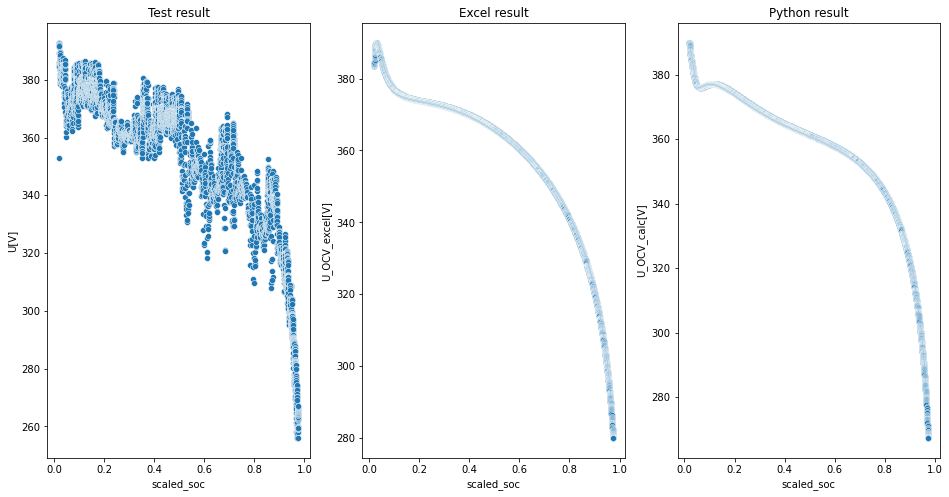

In [14]:
f = plt.figure(figsize=(16, 8))
ax1 = f.add_subplot(1, 3, 1)
ax2 = f.add_subplot(1, 3, 2)
ax3 = f.add_subplot(1, 3, 3)

sns.scatterplot(x='scaled_soc', y='U[V]', palette='hls', data=df_joaquim, ax=ax1)
ax1.set_title('Test result')

df_joaquim['U_OCV_excel[V]'] = OCV_excel_result
sns.scatterplot(x='scaled_soc', y='U_OCV_excel[V]', palette='hls', data=df_joaquim, ax=ax2)
ax2.set_title('Excel result')


sns.scatterplot(x='scaled_soc', y='U_OCV_calc[V]', palette='hls', data=df_joaquim, ax=ax3)
ax3.set_title('Python result')

In [15]:
def electric_charge_v1(df, R, C):
    a = 1
    b = 0
    Q_0 = 0
    Tau = R*C
    n=1
    dt = df['t_acumulated[s]'].diff().iloc[1]    
    df.loc[df.index[0], 'Q'] = 0
    # Calculate the SOC column iteratively
    for i in range(1, len(df)):
        actual_current = df.loc[df.index[i], 'I[A]']
        past_charge = df.loc[df.index[i-1], 'Q']
        df.loc[df.index[i], 'Q'] =  a*Tau - b*Tau**2 + (past_charge - a*Tau + b*Tau**2)*np.exp(-dt/Tau)
        #df.loc[df.index[i], 'Q'] =  (a*actual_current*Tau -b*Tau**2) + (past_charge-a*actual_current*Tau+b*Tau**2)*np.exp(-t/Tau)    
    return df['Q']

def electric_charge_v2(df, R, C):
    current = df['I[A]']
    a = 1
    b = 0
    Q_0 = 0
    Tau = R*C
    n=1
    t = 1
    Q = np.exp(-t / Tau) * (a*Tau*(np.exp(t / Tau) -1)
                                      + b*Tau*(np.exp(t / Tau)*(t - Tau) + Tau)
                                            + Q_0)
    Q = (a*current*Tau -b*Ta**2) + ()
    return Q

def voltage_ECM(df, coeff, test=False):
    current = df['I[A]']
    if test: 
        x = df['U_OCV_calc[V]'] 
    else:
        x = df['Uo_OCV'] 
    R_0 = coeff[0]
    R_1 = coeff[1]
    R_2 = coeff[2]
    C_1 = coeff[3]
    C_2 = coeff[4]
    Q_1 = electric_charge_v1(df, R_1, C_1)
    Q_2 = electric_charge_v1(df, R_2, C_2)
    U_ECM = x - R_0*current - Q_1/C_1 - Q_1/C_2
    return U_ECM

In [16]:
 def electric_charge_opt_v1(df, R, C):
    a = 1
    b = 0
    Q_0 = 0
    Tau = R*C
    n=1
    dt = df['t_acumulated[s]'].diff().iloc[1]

    df.loc[df.index[0], 'Q'] = 0
    # Calculate the SOC column iteratively
    for i in range(1, len(df)):
        actual_current = df.loc[df.index[i], 'I[A]']
        past_charge = df.loc[df.index[i-1], 'Q']
        # df.loc[df.index[i], 'Q'] =  (a*actual_current*Tau -b*Tau**2) + (past_charge-a*actual_current*Tau+b*Tau**2)*np.exp(-dt/Tau)
        df.loc[df.index[i], 'Q'] =  a*Tau - b*Tau**2 + (past_charge - a*Tau + b*Tau**2)*np.exp(-dt/Tau)
    return df['Q']

def electric_charge_opt_v2(R, C):
    a = 1
    b = 0
    Q_0 = 0
    Tau = R*C
    n=1
    t = df_joaquim['t_acumulated[s]']
    Q = np.exp(-t / Tau) * (a*Tau*(np.exp(t / Tau) -1)
                            + b*Tau*(np.exp(t / Tau)*(t - Tau) + Tau)
                            + Q_0)
    return Q

def voltage_opt(x, R_0, R_1, C_1, R_2, C_2):
    current = x['I[A]']
    U_0 = x['U_OCV_calc[V]']
    Q_1 = electric_charge_opt_v1(x, R_1, C_1)
    Q_2 = electric_charge_opt_v1(x, R_2, C_2)
    y = U_0 - R_0*current - Q_1/C_1 - Q_1/C_2
    return y
    
start = timeit.default_timer()
x = df_joaquim
y = np.array(df_joaquim['U[V]'])

ECM_python_coeffs, pcov = curve_fit(voltage_opt, xdata = x, ydata = y,maxfev=1000)

df_joaquim['U_ECM_calc[V]'] = voltage_ECM(df_joaquim, ECM_python_coeffs, True)
print("Duration: ", timeit.default_timer() - start)
print(ECM_python_coeffs)

C:\Users\muril\conda\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Duration:  294.4310751
[ 1.48382899e-01  1.00000000e+00  1.11912669e+04  1.00325914e+04
 -6.63226664e+02]


In [17]:
ECM_excel_coeffs = [6.0491e-02, 6.6812e-02, -4.43066e-03, 1.4610e-03, -1.1064]
print("Excel result")
print("Coefficients (R0, R1, R2, C1, C2): ", ECM_excel_coeffs)
ECM_excel_result = voltage_ECM(df_joaquim, ECM_excel_coeffs)
ECM_MAE_excel, ECM_MSE_excel, ECM_RMSE_excel, ECM_R2_excel = calculate_metrics(df_joaquim['U[V]'], ECM_excel_result)

print("\nPython result")
print("Coefficients (R0, R1, R2, C1, C2): ", ECM_python_coeffs)
ECM_python_result = voltage_ECM(df_joaquim, ECM_python_coeffs, True)
ECM_MAE_python, ECM_MSE_python, ECM_RMSE_python, ECM_R2_python = calculate_metrics(df_joaquim['U[V]'], ECM_python_result)

Excel result
Coefficients (R0, R1, R2, C1, C2):  [0.060491, 0.066812, -0.00443066, 0.001461, -1.1064]
MAE:  7.102631652730586 
MSE:  72.0720427403079 
RMSE:  8.489525472033634 
R²:  0.8913513915678429

Python result
Coefficients (R0, R1, R2, C1, C2):  [ 1.48382899e-01  1.00000000e+00  1.11912669e+04  1.00325914e+04
 -6.63226664e+02]
MAE:  3.5557316576345035 
MSE:  18.466490486721238 
RMSE:  4.297265466168135 
R²:  0.9721617645660843


Text(0.5, 1.0, 'Python result')

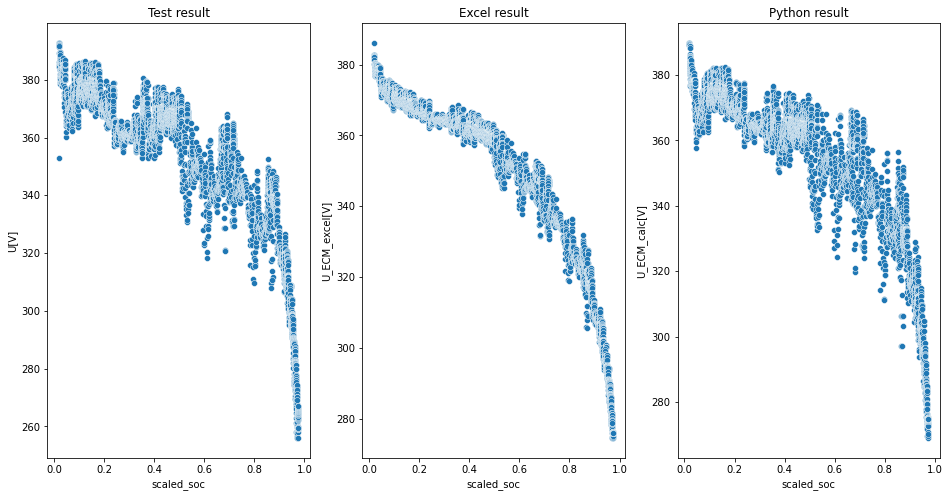

In [18]:
f = plt.figure(figsize=(16, 8))
ax1 = f.add_subplot(1, 3, 1)
ax2 = f.add_subplot(1, 3, 2)
ax3 = f.add_subplot(1, 3, 3)

sns.scatterplot(x='scaled_soc', y='U[V]', palette='hls', data=df_joaquim, ax=ax1)
ax1.set_title('Test result')

df_joaquim['U_ECM_excel[V]'] = ECM_excel_result
sns.scatterplot(x='scaled_soc', y='U_ECM_excel[V]', palette='hls', data=df_joaquim, ax=ax2)
ax2.set_title('Excel result')

df_joaquim['U_ECM_calc[V]'] = ECM_python_result
sns.scatterplot(x='scaled_soc', y='U_ECM_calc[V]', palette='hls', data=df_joaquim, ax=ax3)
ax3.set_title('Python result')

# Execução junto

In [19]:
# Otimização partindo do zero
def voltage_OCV_opt(x, k_0, k_1, k_2, k_3, k_4, k_5, k_6, k_7):
    y = k_0 + k_1/x + k_2/x**2 + k_3/x**3 + k_4/x**4 + k_5*x + k_6*np.log(x) + k_7*np.log(1-x)
    return y

def electric_charge_opt_v1(df, R, C):
    a = 1
    b = 0
    Q_0 = 0
    Tau = R*C
    n=1
    t = 1  
   
    
    df.loc[df.index[0], 'Q'] = 0
    # Calculate the SOC column iteratively
    for i in range(1, len(df)):
        actual_current = df.loc[df.index[i], 'I[A]']
        past_charge = df.loc[df.index[i-1], 'Q']
        df.loc[df.index[i], 'Q'] =  (a*actual_current*Tau -b*Tau**2) + (past_charge-a*actual_current*Tau+b*Tau**2)*np.exp(-t/Tau)    
    return df['Q']

def electric_charge_opt_v2(R, C):
    a = 1
    b = 0
    Q_0 = 0
    Tau = R*C
    n=1
    t = df['t_acumulated[s]']
    Q = np.exp(-t / Tau) * (a*Tau*(np.exp(t / Tau) -1)
                            + b*Tau*(np.exp(t / Tau)*(t - Tau) + Tau)
                            + Q_0)
    return Q

def voltage_opt(x, k_0, k_1, k_2, k_3, k_4, k_5, k_6, k_7, R_0, R_1, C_1, R_2, C_2):
    current = x['I[A]']
    U_0 = voltage_OCV_opt(x['scaled_soc'], k_0, k_1, k_2, k_3, k_4, k_5, k_6, k_7)
    Q_1 = electric_charge_opt_v1(x, R_1, C_1)
    Q_2 = electric_charge_opt_v1(x, R_2, C_2)
    y = U_0 - R_0*current - Q_1/C_1 - Q_1/C_2
    return y
    
start = timeit.default_timer() 
x = df_joaquim
y = np.array(df_joaquim['U[V]'])
OCV_ECM_python_coeffs, pcov = curve_fit(voltage_opt, xdata = x, ydata = y,maxfev=10000)

df_joaquim['U_OCV_ECM_calc[V]'] = voltage_ECM(df_joaquim, OCV_ECM_python_coeffs[-5:], True)
print("Duration: ", timeit.default_timer() - start)
print(OCV_ECM_python_coeffs)

C:\Users\muril\conda\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Duration:  517.7275579000001
[-1.15789837e+02 -2.48456984e+01  8.79194459e-01 -1.66060133e-02
  1.20189109e-04  1.69728478e+04 -1.37662547e+02  5.44264063e+01
  8.80436911e-02  1.00000000e+00  1.14908801e+01 -6.79303057e+03
  3.70142500e+03]


x = [-1.15789837e+02 -2.48456984e+01  8.79194459e-01 -1.66060133e-02
  1.20189109e-04  1.69728478e+04 -1.37662547e+02  5.44264063e+01
  8.80436911e-02  1.00000000e+00  1.14908801e+01 -6.79303057e+03
  3.70142500e+03]

In [21]:
print("Excel result")
OCV_ECM_excel_coeffs = [6.0491e-02, 6.6812e-02, -4.43066e-03, 1.4610e-03, -1.1064]
print("Coefficients (R0, R1, R2, C1, C2): ", OCV_ECM_excel_coeffs)
OCV_ECM_excel_result = voltage_ECM(df_joaquim, OCV_ECM_excel_coeffs)
OCV_ECM_MAE_excel, OCV_ECM_MSE_excel, OCV_ECM_RMSE_excel, OCV_ECM_R2_excel = calculate_metrics(df_joaquim['U[V]'], OCV_ECM_excel_result)

print("\nPython result")
print("Coefficients (R0, R1, R2, C1, C2): ", OCV_ECM_python_coeffs)
OCV_ECM_python_result = voltage_ECM(df_joaquim, OCV_ECM_python_coeffs[-5:], True)
OCV_ECM_MAE_python, OCV_ECM_MSE_python, OCV_ECM_RMSE_python, OCV_ECM_R2_python = calculate_metrics(df_joaquim['U[V]'], OCV_ECM_python_result)

Excel result
Coefficients (R0, R1, R2, C1, C2):  [0.060491, 0.066812, -0.00443066, 0.001461, -1.1064]
MAE:  7.102631652730586 
MSE:  72.0720427403079 
RMSE:  8.489525472033634 
R²:  0.8913513915678429

Python result
Coefficients (R0, R1, R2, C1, C2):  [-1.15789837e+02 -2.48456984e+01  8.79194459e-01 -1.66060133e-02
  1.20189109e-04  1.69728478e+04 -1.37662547e+02  5.44264063e+01
  8.80436911e-02  1.00000000e+00  1.14908801e+01 -6.79303057e+03
  3.70142500e+03]
MAE:  4.802232686520317 
MSE:  34.26267754783096 
RMSE:  5.853432971157265 
R²:  0.9483490116945221


Text(0.5, 1.0, 'Python result')

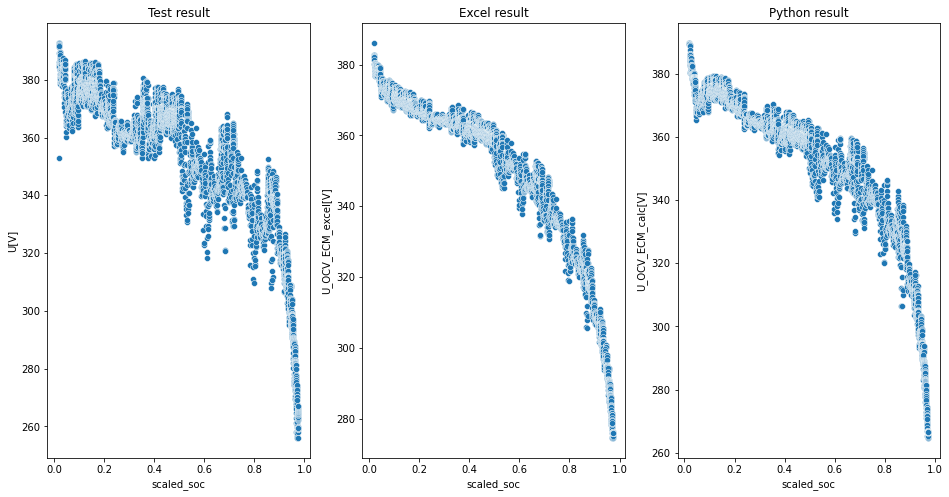

In [22]:
f = plt.figure(figsize=(16, 8))
ax1 = f.add_subplot(1, 3, 1)
ax2 = f.add_subplot(1, 3, 2)
ax3 = f.add_subplot(1, 3, 3)

sns.scatterplot(x='scaled_soc', y='U[V]', palette='hls', data=df_joaquim, ax=ax1)
ax1.set_title('Test result')

df_joaquim['U_OCV_ECM_excel[V]'] = OCV_ECM_excel_result
sns.scatterplot(x='scaled_soc', y='U_OCV_ECM_excel[V]', palette='hls', data=df_joaquim, ax=ax2)
ax2.set_title('Excel result')

df_joaquim['U_OCV_ECM_calc[V]'] = OCV_ECM_python_result
sns.scatterplot(x='scaled_soc', y='U_OCV_ECM_calc[V]', palette='hls', data=df_joaquim, ax=ax3)
ax3.set_title('Python result')

In [23]:
# Otimização partindo dos resultados da otimização feita separadamente
def voltage_OCV_opt(x, k_0, k_1, k_2, k_3, k_4, k_5, k_6, k_7):
    y = k_0 + k_1/x + k_2/x**2 + k_3/x**3 + k_4/x**4 + k_5*x + k_6*np.log(x) + k_7*np.log(1-x)
    return y

def electric_charge_opt_v1(df, R, C):
    a = 1
    b = 0
    Q_0 = 0
    Tau = R*C
    n=1
    t = 1  
   
    
    df.loc[df.index[0], 'Q'] = 0
    # Calculate the SOC column iteratively
    for i in range(1, len(df)):
        actual_current = df.loc[df.index[i], 'I[A]']
        past_charge = df.loc[df.index[i-1], 'Q']
        df.loc[df.index[i], 'Q'] =  (a*actual_current*Tau -b*Tau**2) + (past_charge-a*actual_current*Tau+b*Tau**2)*np.exp(-t/Tau)    
    return df['Q']

def electric_charge_opt_v2(R, C):
    a = 1
    b = 0
    Q_0 = 0
    Tau = R*C
    n=1
    t = df['t_acumulated[s]']
    Q = np.exp(-t / Tau) * (a*Tau*(np.exp(t / Tau) -1)
                            + b*Tau*(np.exp(t / Tau)*(t - Tau) + Tau)
                            + Q_0)
    return Q

def voltage_opt(x, k_0, k_1, k_2, k_3, k_4, k_5, k_6, k_7, R_0, R_1, C_1, R_2, C_2):
    current = x['I[A]']
    U_0 = voltage_OCV_opt(x['scaled_soc'], k_0, k_1, k_2, k_3, k_4, k_5, k_6, k_7)
    Q_1 = electric_charge_opt_v1(x, R_1, C_1)
    Q_2 = electric_charge_opt_v1(x, R_2, C_2)
    y = U_0 - R_0*current - Q_1/C_1 - Q_1/C_2
    return y
    
start = timeit.default_timer() 
x = df_joaquim
y = np.array(df_joaquim['U[V]'])
initial_guess = np.concatenate((OCV_python_coeffs, ECM_python_coeffs))
OCV_ECM_python_coeffs_v2, pcov = curve_fit(voltage_opt, xdata = x, ydata = y, p0=initial_guess, maxfev=10000)

df_joaquim['U_OCV_ECM_calc_v2[V]'] = voltage_ECM(df_joaquim, OCV_ECM_python_coeffs_v2[-5:], True)
print("Duration: ", timeit.default_timer() - start)
print(OCV_ECM_python_coeffs_v2)

C:\Users\muril\conda\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Duration:  600.0143488000001
[ 2.25759995e+02 -2.26135477e+01  7.53029633e-01 -1.32426976e-02
  8.89978140e-05  6.79504347e+01 -1.30943093e+02  5.46175507e+01
  1.73231500e-01  1.00000000e+00 -5.45183185e+04  4.05457008e+05
 -9.59725989e+02]


In [24]:
print("\nPython result")
print("Coefficients (R0, R1, R2, C1, C2): ", OCV_ECM_python_coeffs_v2)
OCV_ECM_python_result_v2 = voltage_ECM(df_joaquim, OCV_ECM_python_coeffs_v2[-5:], True)
OCV_ECM_MAE_python_v2, OCV_ECM_MSE_python_v2, OCV_ECM_RMSE_python_v2, OCV_ECM_R2_python_v2 = calculate_metrics(df_joaquim['U[V]'], OCV_ECM_python_result_v2)


Python result
Coefficients (R0, R1, R2, C1, C2):  [ 2.25759995e+02 -2.26135477e+01  7.53029633e-01 -1.32426976e-02
  8.89978140e-05  6.79504347e+01 -1.30943093e+02  5.46175507e+01
  1.73231500e-01  1.00000000e+00 -5.45183185e+04  4.05457008e+05
 -9.59725989e+02]
MAE:  4.067203014883495 
MSE:  23.458693596627114 
RMSE:  4.843417553404529 
R²:  0.9646360181007546


Text(0.5, 1.0, 'Python result')

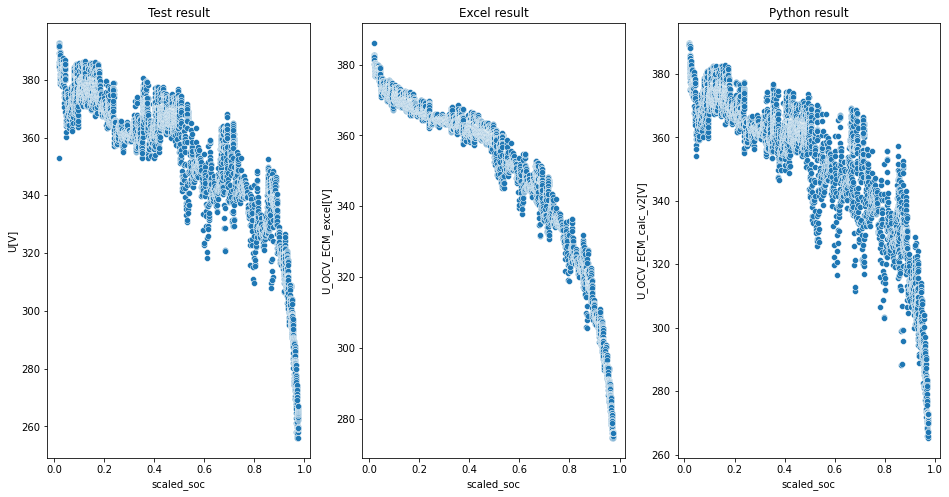

In [25]:
f = plt.figure(figsize=(16, 8))
ax1 = f.add_subplot(1, 3, 1)
ax2 = f.add_subplot(1, 3, 2)
ax3 = f.add_subplot(1, 3, 3)

sns.scatterplot(x='scaled_soc', y='U[V]', palette='hls', data=df_joaquim, ax=ax1)
ax1.set_title('Test result')

df_joaquim['U_OCV_ECM_excel[V]'] = OCV_ECM_excel_result
sns.scatterplot(x='scaled_soc', y='U_OCV_ECM_excel[V]', palette='hls', data=df_joaquim, ax=ax2)
ax2.set_title('Excel result')

df_joaquim['U_OCV_ECM_calc[V]'] = OCV_ECM_python_result
sns.scatterplot(x='scaled_soc', y='U_OCV_ECM_calc_v2[V]', palette='hls', data=df_joaquim, ax=ax3)
ax3.set_title('Python result')

------

# Test with multiple dataframes

OCV_python_coeffs = [k_0, k_1, k_2, k_3, k_4, k_5, k_6, k_7] 

ECM_python_coeffs = [R_0, R_1, C_1, R_2, C_2] 

ECM_OCV_python_coeffs = [k_0, k_1, k_2, k_3, k_4, k_5, k_6, k_7, R_0, R_1, C_1, R_2, C_2]

In [26]:
OCV_python_coeffs = [ 2.51251338e+02, -1.85227826e+01,  6.08165819e-01, -1.05460016e-02,
  7.11347866e-05,  2.06886749e+02, -1.06025760e+02,  4.64227202e+01]
ECM_python_coeffs = [ 1.48382899e-01,  1.00000000e+00,  1.11912669e+04,  1.00325914e+04,
 -6.63226664e+02] 

ECM_OCV_python_coeffs = []

2012_Charge 23°C
Index(['t[s]', 'V[mph]', 'F[N]', 'T[°C]', 'SOC[%]', 'U[V]', 'I[A]',
       't_acumulated[s]', 'V[m/s]', 'a[m/s2]'],
      dtype='object')
MAE:  10.410134585994182 
MSE:  663.5321459788166 
RMSE:  25.759117725163193 
R²:  0.29370244851946803
MAE:  7.356627244979563 
MSE:  627.8415146319687 
RMSE:  25.05676584541526 
R²:  0.33169338186586506
2012_Charge 23°C_1Hz
Index(['t[s]', 'V[mph]', 'F[N]', 'T[°C]', 'SOC[%]', 'U[V]', 'I[A]',
       't_acumulated[s]', 'V[m/s]', 'a[m/s2]'],
      dtype='object')
MAE:  10.381245465614239 
MSE:  638.8823082033442 
RMSE:  25.276121304570133 
R²:  0.3021335858627682
MAE:  7.346361026775488 
MSE:  603.3066825402162 
RMSE:  24.5623020610898 
R²:  0.3409936920097577
2012_Charge 35°C
Index(['t[s]', 'V[mph]', 'F[N]', 'T[°C]', 'SOC[%]', 'U[V]', 'I[A]',
       't_acumulated[s]', 'V[m/s]', 'a[m/s2]'],
      dtype='object')
MAE:  5.64935527818872 
MSE:  1025.9091145688008 
RMSE:  32.02981602458561 
R²:  -0.004803870905331076
MAE:  5.104027968805658

C:\Users\muril\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

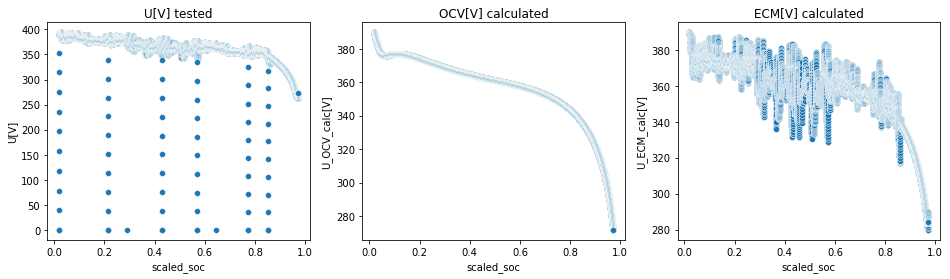

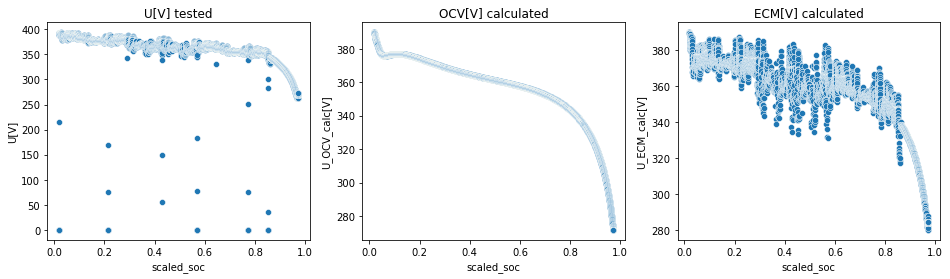

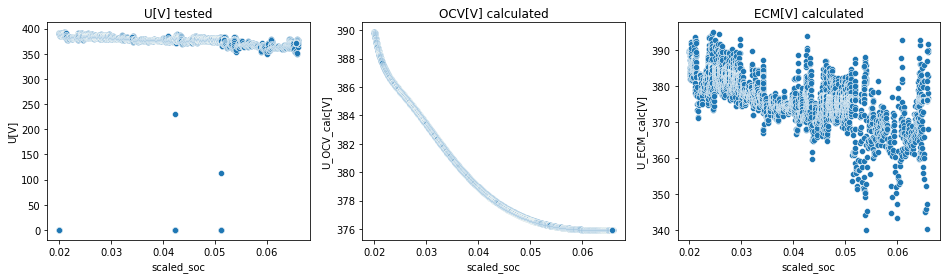

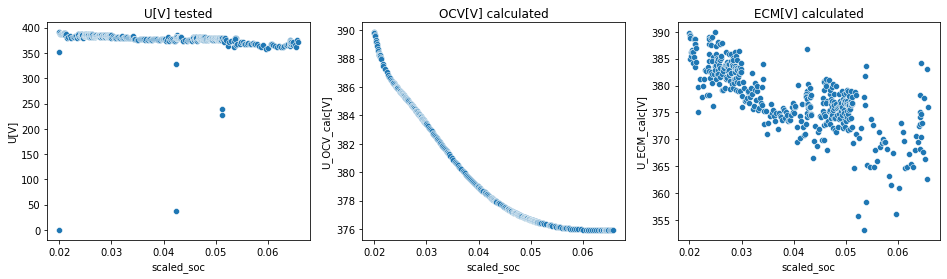

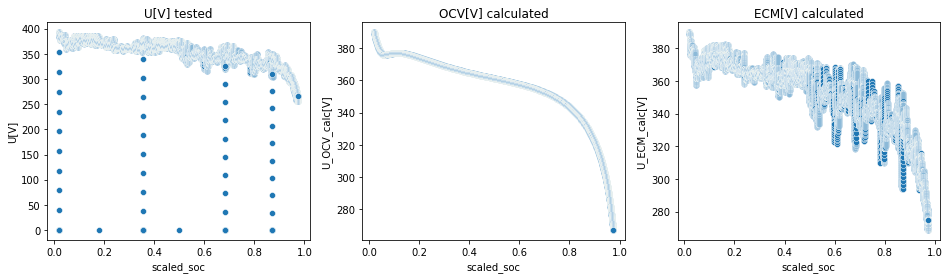

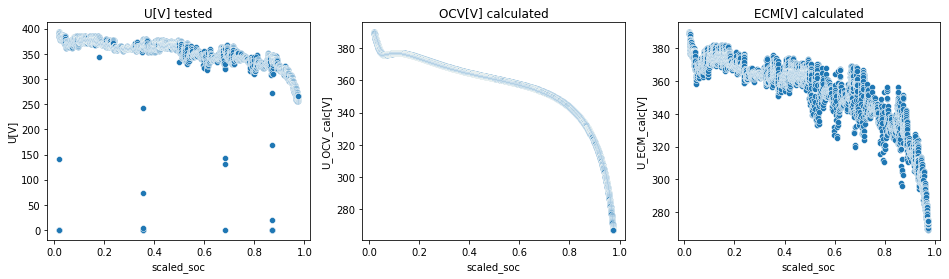

In [27]:
data_path = '../data/processed/bronze'
raw_files = os.listdir(data_path)
df_results = pd.DataFrame()

for idx, filename in enumerate(raw_files):
    if filename.endswith('.parquet'):
        filepath = os.path.join(data_path, filename) 
        print(filename.split('.')[0])
        df_raw = pd.read_parquet(filepath)
        df_processed = (df_raw.pipe(calculate_scaled_soc_v2, 51))
        df_processed['U_OCV_calc[V]'] = voltage_OCV(df_processed, OCV_python_coeffs)
        df_processed['U_ECM_calc[V]'] = voltage_ECM(df_processed, ECM_python_coeffs, True)
        OCV_MAE_python, OCV_MSE_python, OCV_RMSE_python, OCV_R2_python = calculate_metrics(df_processed['U[V]'], df_processed['U_OCV_calc[V]'])
        ECM_MAE_python, ECM_MSE_python, ECM_RMSE_python, ECM_R2_python = calculate_metrics(df_processed['U[V]'], df_processed['U_ECM_calc[V]'])

        result = pd.DataFrame({'Test': filename.split('.')[0], 'OCV_RMSE': OCV_RMSE_python, 'ECM_RMSE': ECM_RMSE_python}, index=[0])
        df_results = pd.concat([df_results, result])
        f = plt.figure(figsize=(16, 4))
        ax1 = f.add_subplot(1, 3, 1)
        ax2 = f.add_subplot(1, 3, 2)
        ax3 = f.add_subplot(1, 3, 3)
        
        sns.scatterplot(x='scaled_soc', y='U[V]', palette='hls', data=df_processed, ax=ax1)
        ax1.set_title('U[V] tested')
        sns.scatterplot(x='scaled_soc', y='U_OCV_calc[V]', palette='hls', data=df_processed, ax=ax2)
        ax2.set_title('OCV[V] calculated')
        sns.scatterplot(x='scaled_soc', y='U_ECM_calc[V]', palette='hls', data=df_processed, ax=ax3)
        ax3.set_title('ECM[V] calculated')


In [36]:
def scatter_plot(df, x_label, y_label, title, ax):
    sns.scatterplot(x=x_label, y=y_label, palette='hls', data=df, ax=ax)
    ax.set_title(title)
    ax.set_ylim([250, 400])

In [45]:
net_currents = {
    '2012_Charge 23°C_1Hz': 50,
    '2012_Charge 35°C_1Hz': 24,
    '2012_Charge-7°C_1Hz': 51,
    '2013_Charge 23°C_1Hz': 53,
    '2013_Charge 35°C_1Hz': 54, 
    '2013_Charge-7°C_1Hz': 49
}

2012_Charge 23°C_
2012_Charge 35°C_
2012_Charge-7°C_
2013_Charge 23°C_


C:\Users\muril\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2013_Charge 35°C_


C:\Users\muril\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


2013_Charge-7°C_


C:\Users\muril\conda\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


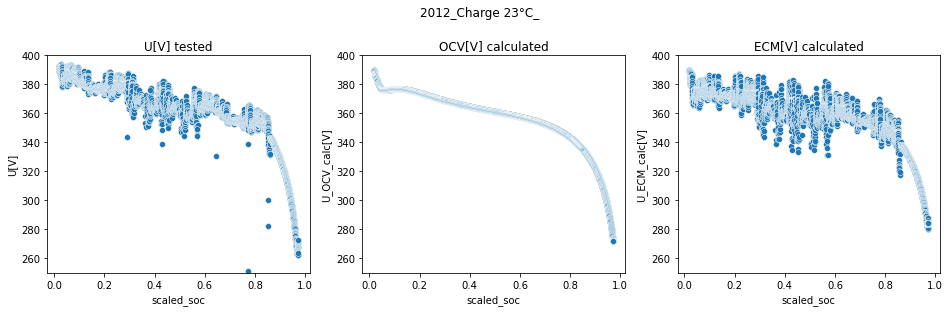

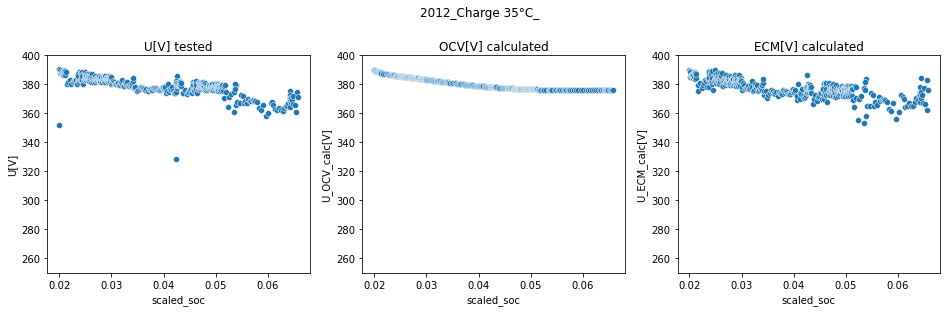

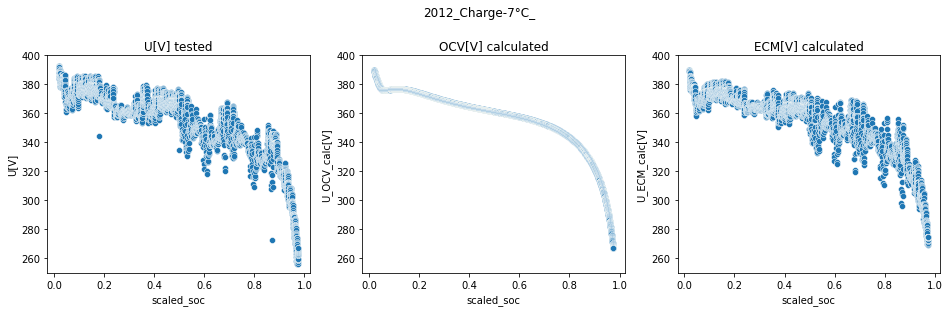

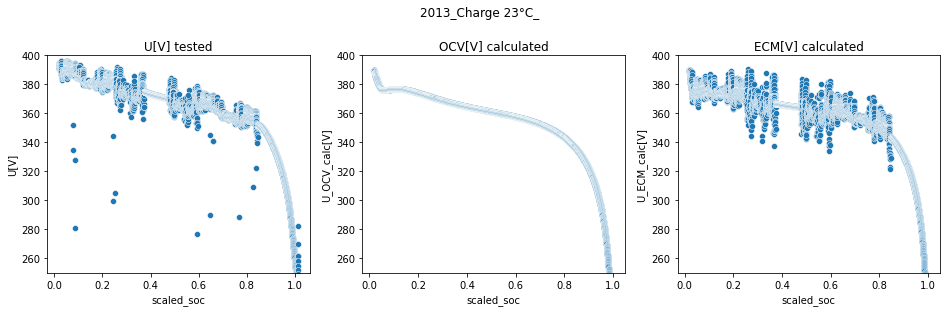

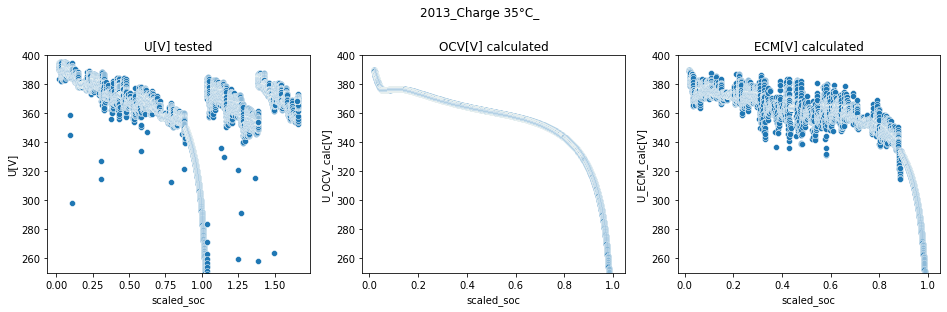

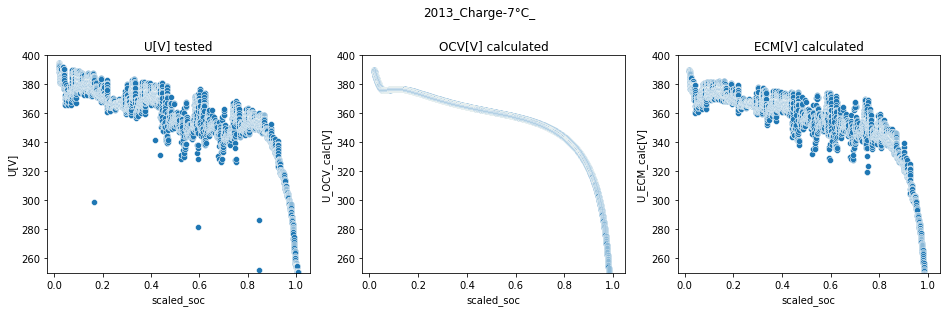

In [48]:

for idx, filename in enumerate(raw_files):
    if filename.endswith('1Hz.parquet'):
        filepath = os.path.join(data_path, filename) 
        charge = filename.split('.')[0]
        charge = charge.replace('1Hz', '')
        print(charge)
        df_raw = pd.read_parquet(filepath)
        net_current_charge = net_currents.get(charge)
        df_processed = (df_raw.pipe(calculate_scaled_soc_v2, 51))
        df_processed['U_OCV_calc[V]'] = voltage_OCV(df_processed, OCV_python_coeffs)
        df_processed['U_ECM_calc[V]'] = voltage_ECM(df_processed, ECM_python_coeffs, True)
        #OCV_MAE_python, OCV_MSE_python, OCV_RMSE_python, OCV_R2_python = calculate_metrics(df_processed['U[V]'], df_processed['U_OCV_calc[V]'])
        #ECM_MAE_python, ECM_MSE_python, ECM_RMSE_python, ECM_R2_python = calculate_metrics(df_processed['U[V]'], df_processed['U_ECM_calc[V]'])

        result = pd.DataFrame({'Test': filename.split('.')[0], 'OCV_RMSE': OCV_RMSE_python, 'ECM_RMSE': ECM_RMSE_python}, index=[0])
        df_results = pd.concat([df_results, result])
        f = plt.figure(figsize=(16, 4))
        f.suptitle(f"{charge}", y=1.05)
        ax1 = f.add_subplot(1, 3, 1)
        ax2 = f.add_subplot(1, 3, 2)
        ax3 = f.add_subplot(1, 3, 3)
        
        #sns.scatterplot(x='scaled_soc', y='U[V]', palette='hls', data=df_processed, ax=ax1)
        #ax1.set_title('U[V] tested')
        # ax1.set_ylim([250, 400])
        scatter_plot(df_processed, 'scaled_soc', 'U[V]', 'U[V] tested', ax1)
        scatter_plot(df_processed, 'scaled_soc', 'U_OCV_calc[V]', 'OCV[V] calculated', ax2)
        scatter_plot(df_processed, 'scaled_soc', 'U_ECM_calc[V]', 'ECM[V] calculated', ax3)